# Predictive Analysis: Obesity ~ Diet Composition

**Complete predictive analysis on country-year panel data**

## Objectives
1. **(A)** Fit simple linear regression: Obesity ~ FatShare
2. **(B)** Fit multiple regression with diet composition covariates
3. **(C)** Produce linear trend forecast of global obesity to 2030

## Outputs
- Model summaries and diagnostics
- Prediction plots and visualizations
- Forecast with 95% prediction intervals
- CSV files with predictions and residuals

---


## Setup Instructions

**⚠️ IMPORTANT: Select the correct kernel!**

This notebook requires packages installed in the virtual environment. 

### To fix "ModuleNotFoundError":

1. **In Jupyter, go to**: `Kernel` → `Change Kernel` → Select **"Python (Bell-Labs venv)"**

2. **If the kernel is not listed**, run this in terminal:
   ```bash
   source venv/bin/activate
   pip install ipykernel
   python -m ipykernel install --user --name=bell-labs-venv --display-name "Python (Bell-Labs venv)"
   ```
   Then restart Jupyter and select the new kernel.

3. **Alternative**: Install packages in your current Python environment:
   ```bash
   pip install --break-system-packages pandas numpy statsmodels scikit-learn matplotlib seaborn scipy
   ```
   (Note: This installs system-wide, use with caution)

**The virtual environment (`venv/`) already has all packages installed!** You just need to use the correct kernel.

---


In [26]:
# Import required libraries with error handling
try:
    import pandas as pd
    import numpy as np
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy import stats
    import json
    from pathlib import Path
    import warnings
    warnings.filterwarnings('ignore')
    
    print("✅ All libraries imported successfully!")
    
except ImportError as e:
    print(f"❌ ERROR: Missing required package: {e}")
    print("\n" + "="*70)
    print("SETUP INSTRUCTIONS")
    print("="*70)
    print("\n1. Activate the virtual environment:")
    print("   source venv/bin/activate")
    print("\n2. Install required packages:")
    print("   pip install -r requirements.txt")
    print("\n3. Or install individually:")
    print("   pip install pandas numpy statsmodels scikit-learn matplotlib seaborn scipy")
    print("\n4. Restart the Jupyter kernel and run this cell again.")
    print("\n" + "="*70)
    raise

# Set random seed for reproducibility
np.random.seed(42)

# Set up paths
PROJECT_ROOT = Path().resolve().parent
DATA_DIR = PROJECT_ROOT / "data" / "processed" / "final"
OUTPUT_DIR = PROJECT_ROOT / "data" / "outputs"
OUTPUT_PLOTS = OUTPUT_DIR / "plots"

# Create output directories
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_PLOTS.mkdir(parents=True, exist_ok=True)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(f"\n📁 Data directory: {DATA_DIR}")
print(f"📁 Output directory: {OUTPUT_DIR}")
print(f"✅ Setup complete! Ready to run analysis.")


✅ All libraries imported successfully!

📁 Data directory: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/processed/final
📁 Output directory: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/outputs
✅ Setup complete! Ready to run analysis.


## STEP 0: Load & Basic Checks


In [27]:
# Load data
print("📂 Loading master panel data...")
df = pd.read_csv(DATA_DIR / "master_panel_final.csv")
print(f"✅ Loaded {len(df):,} rows, {len(df.columns)} columns")

# Basic checks
print(f"\n📊 Dataset Overview:")
print(f"   • Total rows: {len(df):,}")
print(f"   • Unique countries: {df['country'].nunique()}")
print(f"   • Year range: {int(df['year'].min())} - {int(df['year'].max())}")
print(f"   • Key columns: {', '.join(['country', 'year', 'obesity_pct', 'energy_kcal_day', 'fat_g_day'])}")

# Ensure correct data types
df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')
df['obesity_pct'] = pd.to_numeric(df['obesity_pct'], errors='coerce')
df['energy_kcal_day'] = pd.to_numeric(df['energy_kcal_day'], errors='coerce')

# Filter to 2010-2022
print(f"\n🔍 Filtering to years 2010-2022...")
initial_count = len(df)
df = df[(df['year'] >= 2010) & (df['year'] <= 2022)].copy()
print(f"✅ Filtered to {len(df):,} rows (removed {initial_count - len(df):,} rows)")

# Calculate fat_share if not present
if 'fat_share' not in df.columns:
    print("\n📐 Calculating fat_share from fat_g_day and energy_kcal_day...")
    df['fat_share'] = (df['fat_g_day'] * 9) / df['energy_kcal_day'] * 100
    print(f"✅ Calculated fat_share for {df['fat_share'].notna().sum():,} rows")

# Calculate sugar_share
if 'sugar_share' not in df.columns:
    if 'Sugar_share' in df.columns:
        print("\n📐 Using Sugar_share as sugar_share...")
        df['sugar_share'] = df['Sugar_share']
    elif 'sugar_g_day' in df.columns:
        print("\n📐 Calculating sugar_share from sugar_g_day...")
        df['sugar_share'] = (df['sugar_g_day'] * 4) / df['energy_kcal_day'] * 100
    else:
        df['sugar_share'] = np.nan

# Map food group shares
if 'oil_fats_share' not in df.columns and 'Oils & Fats_share' in df.columns:
    df['oil_fats_share'] = df['Oils & Fats_share']
elif 'oil_fats_share' not in df.columns:
    df['oil_fats_share'] = np.nan

if 'meat_share' not in df.columns and 'Meat_share' in df.columns:
    df['meat_share'] = df['Meat_share']
elif 'meat_share' not in df.columns:
    df['meat_share'] = np.nan

# Summary statistics
print("\n📈 Summary Statistics (2010-2022):")
summary_vars = ['obesity_pct', 'fat_share', 'energy_kcal_day', 'sugar_share', 'oil_fats_share', 'meat_share']
summary_stats = {}
for var in summary_vars:
    if var in df.columns and df[var].notna().sum() > 0:
        stats_dict = {
            'mean': df[var].mean(),
            'std': df[var].std(),
            'min': df[var].min(),
            'max': df[var].max()
        }
        summary_stats[var] = stats_dict
        print(f"   {var:20s}: mean={stats_dict['mean']:.2f}, std={stats_dict['std']:.2f}, "
              f"range=[{stats_dict['min']:.2f}, {stats_dict['max']:.2f}]")

display(pd.DataFrame(summary_stats).T.round(2))


📂 Loading master panel data...
✅ Loaded 2,131 rows, 40 columns

📊 Dataset Overview:
   • Total rows: 2,131
   • Unique countries: 169
   • Year range: 2010 - 2022
   • Key columns: country, year, obesity_pct, energy_kcal_day, fat_g_day

🔍 Filtering to years 2010-2022...
✅ Filtered to 2,131 rows (removed 0 rows)

📐 Calculating fat_share from fat_g_day and energy_kcal_day...
✅ Calculated fat_share for 2,131 rows

📐 Using Sugar_share as sugar_share...

📈 Summary Statistics (2010-2022):
   obesity_pct         : mean=20.90, std=11.44, range=[0.67, 70.54]
   fat_share           : mean=27.40, std=7.89, range=[8.77, 46.00]
   energy_kcal_day     : mean=2910.72, std=449.70, range=[1810.45, 3966.57]
   sugar_share         : mean=10.46, std=4.28, range=[1.37, 30.97]
   oil_fats_share      : mean=21.31, std=8.65, range=[1.16, 46.58]
   meat_share          : mean=33.52, std=16.56, range=[2.89, 89.26]


,mean,std,min,max
obesity_pct,20.90,11.44,0.67,70.54
fat_share,27.40,7.89,8.77,46.00
energy_kcal_day,2910.72,449.70,1810.45,3966.57
sugar_share,10.46,4.28,1.37,30.97
oil_fats_share,21.31,8.65,1.16,46.58
meat_share,33.52,16.56,2.89,89.26


## STEP 1: Simple Linear Regression - Obesity ~ FatShare


📊 Simple LR Dataset:
   • Observations (N): 2,131
   • Unique countries: 169

📊 Correlation: r = 0.553, p = 8.69e-171


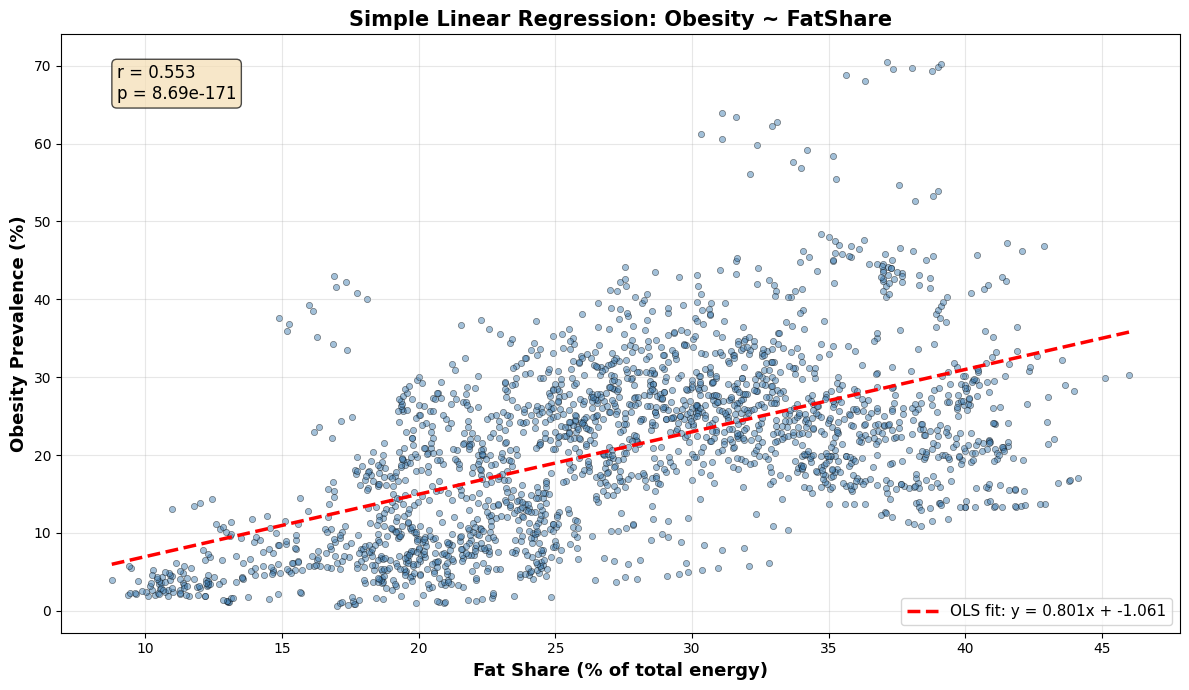

✅ Saved: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/outputs/plots/simple_lr_scatter_fit.png


In [28]:
# Build dataset
df_lr = df[['country', 'year', 'obesity_pct', 'fat_share']].copy()
df_lr = df_lr.dropna(subset=['obesity_pct', 'fat_share'])

print(f"📊 Simple LR Dataset:")
print(f"   • Observations (N): {len(df_lr):,}")
print(f"   • Unique countries: {df_lr['country'].nunique()}")

# Prepare data
X = df_lr['fat_share'].values
y = df_lr['obesity_pct'].values
X_const = sm.add_constant(X)

# Calculate correlation
corr_coef, p_value_corr = stats.pearsonr(X, y)
print(f"\n📊 Correlation: r = {corr_coef:.3f}, p = {p_value_corr:.3g}")

# Exploratory plot
fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(X, y, alpha=0.5, s=20, color='steelblue', edgecolors='black', linewidth=0.5)

# Fit OLS for plot line
z = np.polyfit(X, y, 1)
p = np.poly1d(z)
x_line = np.linspace(X.min(), X.max(), 100)
ax.plot(x_line, p(x_line), "r--", linewidth=2.5, label=f'OLS fit: y = {z[0]:.3f}x + {z[1]:.3f}')

ax.set_xlabel('Fat Share (% of total energy)', fontsize=13, fontweight='bold')
ax.set_ylabel('Obesity Prevalence (%)', fontsize=13, fontweight='bold')
ax.set_title('Simple Linear Regression: Obesity ~ FatShare', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

# Annotate correlation
textstr = f'r = {corr_coef:.3f}\np = {p_value_corr:.3g}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(OUTPUT_PLOTS / "simple_lr_scatter_fit.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {OUTPUT_PLOTS / 'simple_lr_scatter_fit.png'}")


In [29]:
# Fit OLS model
print("🔧 Fitting OLS model...")
model_simple = sm.OLS(y, X_const).fit()

# Display summary
print("\n📊 Model Summary:")
display(model_simple.summary())

# Extract coefficients
coef = model_simple.params[1]
std_err = model_simple.bse[1]
t_stat = model_simple.tvalues[1]
p_value = model_simple.pvalues[1]
r_squared = model_simple.rsquared
rmse = np.sqrt(model_simple.mse_resid)
mae = np.mean(np.abs(model_simple.resid))

print(f"\n📝 Key Statistics:")
print(f"   • Coefficient (b): {coef:.3f} (SE={std_err:.3f}, t={t_stat:.3f}, p={p_value:.3g})")
print(f"   • R²: {r_squared:.3f}")
print(f"   • RMSE: {rmse:.3f}%")
print(f"   • MAE: {mae:.3f}%")

interpretation = (
    f"\n💡 Interpretation:\n"
    f"Each 1 percentage-point increase in fat_share is associated with "
    f"an estimated {coef:.3f} percentage-point increase in obesity prevalence."
)
print(interpretation)

# Save summary
with open(OUTPUT_DIR / "simple_lr_summary.txt", 'w') as f:
    f.write("="*70 + "\n")
    f.write("SIMPLE LINEAR REGRESSION: Obesity ~ FatShare\n")
    f.write("="*70 + "\n\n")
    f.write(str(model_simple.summary()))
    f.write("\n\n" + interpretation)
print(f"\n✅ Saved: {OUTPUT_DIR / 'simple_lr_summary.txt'}")


🔧 Fitting OLS model...

📊 Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     936.6
Date:                Wed, 03 Dec 2025   Prob (F-statistic):          8.69e-171
Time:                        23:49:59   Log-Likelihood:                -7828.1
No. Observations:                2131   AIC:                         1.566e+04
Df Residuals:                    2129   BIC:                         1.567e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0612      0.747     -1.421      0.155      -2.526       0.403
x1             0.8014      0.026     30.604      0.000       0.750       0.853
==============================================================================
Omnibus:                      242.691   Durbin-Watson:                   0.227
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              387.242
Skew:                           0.799   Prob(JB):                     8.16e-85
Kurtosis:                       4.345   Cond. No.                         103.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


📝 Key Statistics:
   • Coefficient (b): 0.801 (SE=0.026, t=30.604, p=8.69e-171)
   • R²: 0.306
   • RMSE: 9.535%
   • MAE: 7.549%

💡 Interpretation:
Each 1 percentage-point increase in fat_share is associated with an estimated 0.801 percentage-point increase in obesity prevalence.

✅ Saved: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/outputs/simple_lr_summary.txt


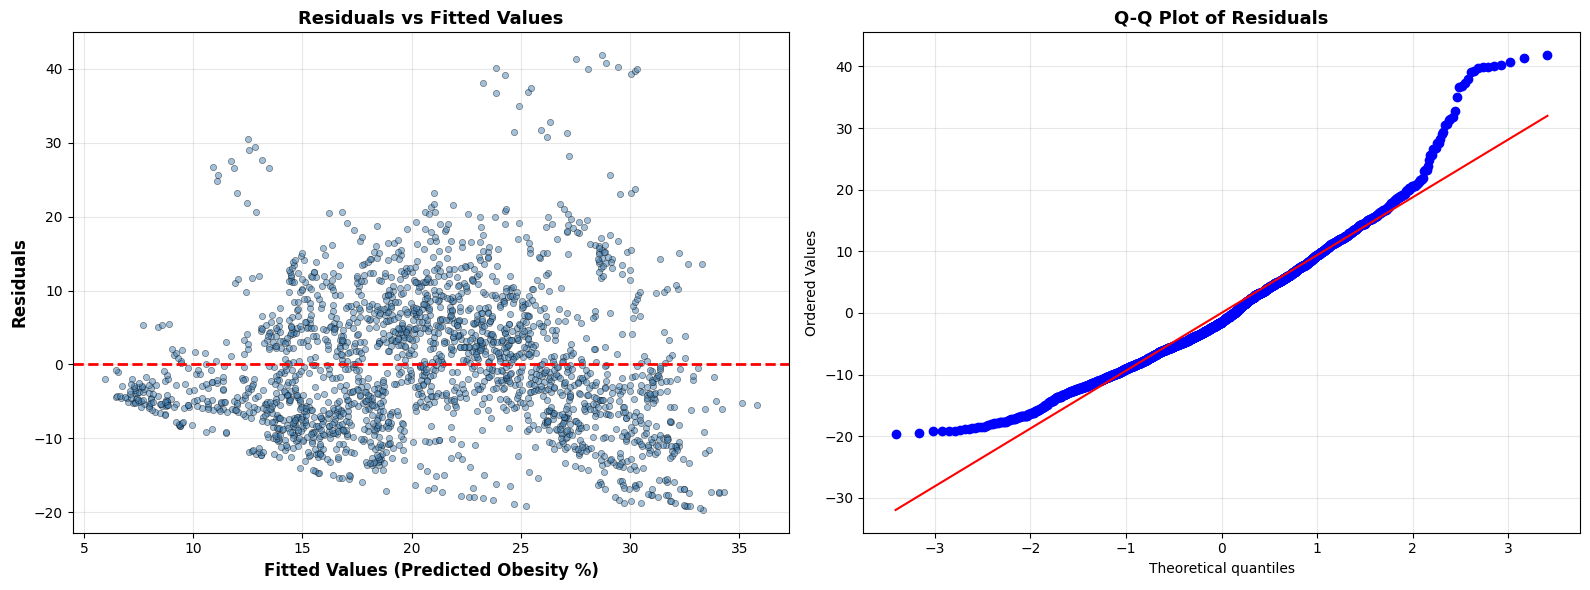

✅ Saved diagnostic plots
✅ Saved predictions and residuals CSVs


In [30]:
# Diagnostics: Residuals vs Fitted
fitted = model_simple.fittedvalues
residuals = model_simple.resid

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Residuals vs Fitted
axes[0].scatter(fitted, residuals, alpha=0.5, s=20, color='steelblue', edgecolors='black', linewidth=0.5)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Fitted Values (Predicted Obesity %)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Residuals', fontsize=12, fontweight='bold')
axes[0].set_title('Residuals vs Fitted Values', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# QQ plot
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot of Residuals', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PLOTS / "simple_lr_resid_vs_fitted.png", dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT_PLOTS / "simple_lr_qq.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved diagnostic plots")

# Save predictions and residuals
df_lr['obesity_pct_predicted'] = fitted
df_lr['residual'] = residuals
df_lr_output = df_lr[['country', 'year', 'obesity_pct', 'obesity_pct_predicted', 'residual']].copy()
df_lr_output.columns = ['country', 'year', 'obesity_pct_actual', 'obesity_pct_predicted', 'residual']
df_lr_output.to_csv(OUTPUT_DIR / "simple_lr_predictions.csv", index=False)
df_lr_output[['country', 'year', 'residual']].to_csv(OUTPUT_DIR / "simple_lr_residuals.csv", index=False)
print(f"✅ Saved predictions and residuals CSVs")


## STEP 2: Multiple Regression - Obesity ~ Diet Composition


In [31]:
# Build dataset
predictors = ['fat_share', 'energy_kcal_day', 'sugar_share', 'oil_fats_share', 'meat_share']
df_multi = df[['country', 'year', 'obesity_pct'] + predictors].copy()

# Check which predictors are available
available_predictors = [p for p in predictors if p in df_multi.columns and df_multi[p].notna().sum() > 0]
missing_predictors = [p for p in predictors if p not in available_predictors]

print(f"📊 Multiple LR Dataset:")
print(f"   • Available predictors: {available_predictors}")
if missing_predictors:
    print(f"   ⚠️  Missing predictors: {missing_predictors}")

# Drop rows with NaN
df_multi = df_multi.dropna(subset=['obesity_pct'] + available_predictors)
print(f"   • Observations (N): {len(df_multi):,}")
print(f"   • Unique countries: {df_multi['country'].nunique()}")

# Prepare data
X_multi = df_multi[available_predictors].copy()
y_multi = df_multi['obesity_pct'].values

# Center energy_kcal_day for numerical stability
if 'energy_kcal_day' in X_multi.columns:
    energy_mean = X_multi['energy_kcal_day'].mean()
    X_multi['energy_kcal_day'] = X_multi['energy_kcal_day'] - energy_mean
    print(f"   • Centered energy_kcal_day (mean={energy_mean:.1f})")

# Standardized version for beta coefficients
X_multi_std = (X_multi - X_multi.mean()) / X_multi.std()

# Train/test split
print(f"\n🔧 Splitting into train/test (80/20)...")
X_train, X_test, y_train, y_test = train_test_split(
    X_multi, y_multi, test_size=0.2, random_state=42, shuffle=True
)
X_train_std, X_test_std, _, _ = train_test_split(
    X_multi_std, y_multi, test_size=0.2, random_state=42, shuffle=True
)

print(f"   • Training set: {len(X_train):,} observations")
print(f"   • Test set: {len(X_test):,} observations")


📊 Multiple LR Dataset:
   • Available predictors: ['fat_share', 'energy_kcal_day', 'sugar_share', 'oil_fats_share', 'meat_share']
   • Observations (N): 2,131
   • Unique countries: 169
   • Centered energy_kcal_day (mean=2910.7)

🔧 Splitting into train/test (80/20)...
   • Training set: 1,704 observations
   • Test set: 427 observations


In [32]:
# Fit OLS on training set
print("🔧 Fitting multiple regression on training set...")
X_train_const = sm.add_constant(X_train)
model_multi = sm.OLS(y_train, X_train_const).fit()

# Display summary
print("\n📊 Model Summary (Training Set):")
display(model_multi.summary())

# Save summary
with open(OUTPUT_DIR / "multi_lr_summary.txt", 'w') as f:
    f.write("="*70 + "\n")
    f.write("MULTIPLE LINEAR REGRESSION: Obesity ~ Diet Composition\n")
    f.write("="*70 + "\n\n")
    f.write(f"Predictors: {', '.join(available_predictors)}\n")
    f.write(f"Training observations: {len(X_train):,}\n")
    f.write(f"Test observations: {len(X_test):,}\n\n")
    f.write(str(model_multi.summary()))
print(f"✅ Saved: {OUTPUT_DIR / 'multi_lr_summary.txt'}")


🔧 Fitting multiple regression on training set...

📊 Model Summary (Training Set):


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     228.4
Date:                Wed, 03 Dec 2025   Prob (F-statistic):          1.13e-186
Time:                        23:50:00   Log-Likelihood:                -6142.4
No. Observations:                1704   AIC:                         1.230e+04
Df Residuals:                    1698   BIC:                         1.233e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.5716      1.140     -0.501      0.616      -2.808       1.665
fat_share           0.2833      0.109      2.609      0.009       0.070       0.496
energy_kcal_day     0.0029      0.001      4.463      0.000       0.002       0.004
sugar_share         0.6631      0.054     12.215      0.000       0.557       0.770
oil_fats_share      0.0821      0.061      1.351      0.177      -0.037       0.201
meat_share          0.1502      0.035      4.267      0.000       0.081       0.219
==============================================================================
Omnibus:                      236.289   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              492.639
Skew:                           0.827   Prob(JB):                    1.06e-107
Kurtosis:                       5.051   Cond. No.                     2.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

✅ Saved: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/outputs/multi_lr_summary.txt


📊 Evaluating on test set...
   • Test R²: 0.356
   • Test RMSE: 8.931%
   • Test MAE: 6.766%
✅ Saved: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/outputs/output_multi_lr_test_metrics.json


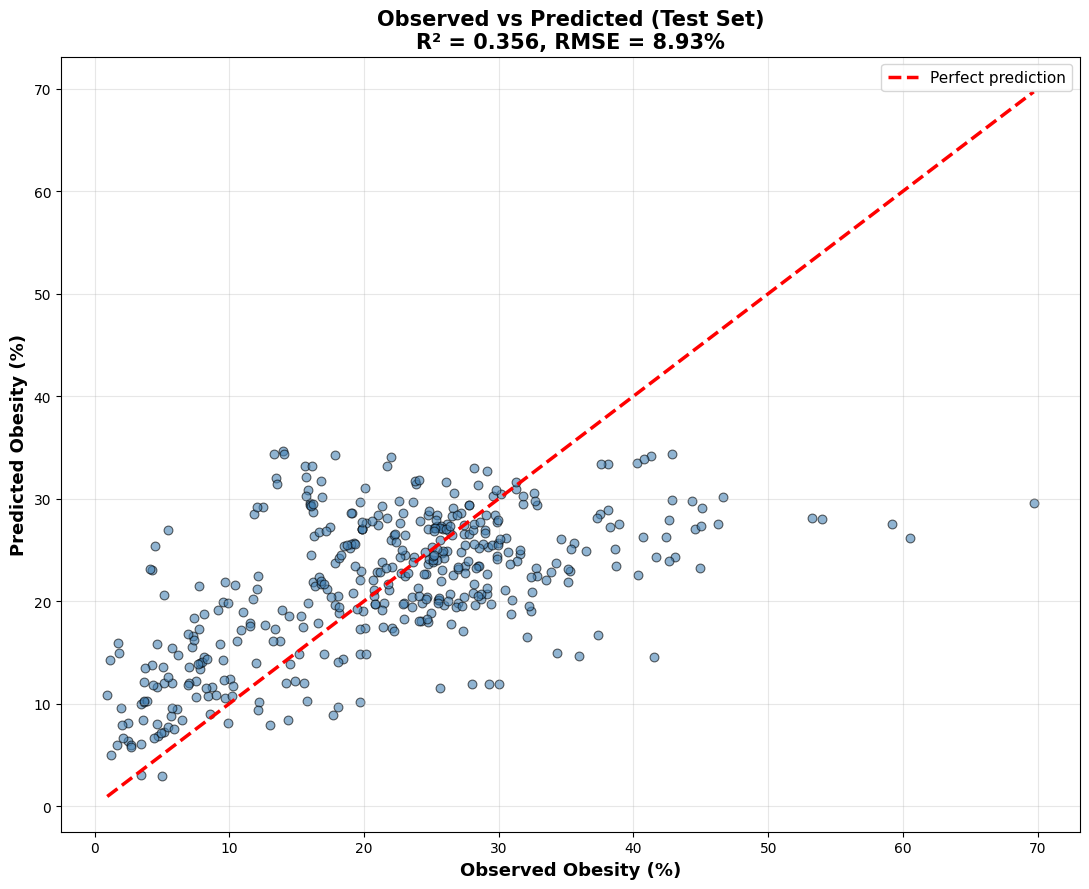

✅ Saved: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/outputs/plots/multi_lr_obs_vs_pred.png


In [33]:
# Evaluate on test set
print("📊 Evaluating on test set...")
X_test_const = sm.add_constant(X_test)
y_pred_test = model_multi.predict(X_test_const)

r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)

test_metrics = {
    'r2_test': float(r2_test),
    'rmse_test': float(rmse_test),
    'mae_test': float(mae_test),
    'n_test': int(len(y_test))
}

print(f"   • Test R²: {r2_test:.3f}")
print(f"   • Test RMSE: {rmse_test:.3f}%")
print(f"   • Test MAE: {mae_test:.3f}%")

# Save metrics
with open(OUTPUT_DIR / "output_multi_lr_test_metrics.json", 'w') as f:
    json.dump(test_metrics, f, indent=2)
print(f"✅ Saved: {OUTPUT_DIR / 'output_multi_lr_test_metrics.json'}")

# Observed vs Predicted plot
fig, ax = plt.subplots(figsize=(11, 9))
ax.scatter(y_test, y_pred_test, alpha=0.6, s=40, color='steelblue', edgecolors='black', linewidth=0.8)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2.5, label='Perfect prediction')
ax.set_xlabel('Observed Obesity (%)', fontsize=13, fontweight='bold')
ax.set_ylabel('Predicted Obesity (%)', fontsize=13, fontweight='bold')
ax.set_title(f'Observed vs Predicted (Test Set)\nR² = {r2_test:.3f}, RMSE = {rmse_test:.2f}%', 
             fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_PLOTS / "multi_lr_obs_vs_pred.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {OUTPUT_PLOTS / 'multi_lr_obs_vs_pred.png'}")


In [34]:
# Standardized coefficients (betas) and VIF
print("📊 Computing standardized coefficients and VIF...")
X_train_std_const = sm.add_constant(X_train_std)
model_multi_std = sm.OLS(y_train, X_train_std_const).fit()

# VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_train_const.columns[1:]  # Exclude constant
vif_data["VIF"] = [variance_inflation_factor(X_train_const.values, i+1) 
                   for i in range(len(X_train_const.columns)-1)]

# Beta coefficients
beta_data = pd.DataFrame({
    'variable': available_predictors,
    'coef': model_multi.params[1:].values,  # Exclude intercept
    'std_coef': model_multi_std.params[1:].values,  # Standardized
    'p_value': model_multi.pvalues[1:].values
})

# Merge with VIF
beta_data = beta_data.merge(vif_data, left_on='variable', right_on='Variable', how='left')
beta_data = beta_data.drop('Variable', axis=1)

print("\n📊 Coefficients, Standardized Coefficients, and VIF:")
display(beta_data.round(3))

beta_data.to_csv(OUTPUT_DIR / "output_multi_lr_betas.csv", index=False)
print(f"\n✅ Saved: {OUTPUT_DIR / 'output_multi_lr_betas.csv'}")

# Interpretation
significant_vars = beta_data[beta_data['p_value'] < 0.05].sort_values('std_coef', key=abs, ascending=False)
if len(significant_vars) > 0:
    strongest = significant_vars.iloc[0]
    print(f"\n💡 Strongest predictor: {strongest['variable']} (coef={strongest['coef']:.3f}, "
          f"std_coef={strongest['std_coef']:.3f}, p={strongest['p_value']:.3g})")
    
    if 'fat_share' in significant_vars['variable'].values:
        fat_row = significant_vars[significant_vars['variable'] == 'fat_share'].iloc[0]
        print(f"   Fat_share: coef={fat_row['coef']:.3f}, p={fat_row['p_value']:.3g}")
    
    print(f"\n   Test R² = {r2_test:.3f}")


📊 Computing standardized coefficients and VIF...

📊 Coefficients, Standardized Coefficients, and VIF:


,variable,coef,std_coef,p_value,VIF
0,fat_share,0.283,2.235,0.009,15.701
1,energy_kcal_day,0.003,1.288,0.000,1.796
2,sugar_share,0.663,2.836,0.000,1.168
3,oil_fats_share,0.082,0.710,0.177,5.831
4,meat_share,0.150,2.488,0.000,7.370



✅ Saved: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/outputs/output_multi_lr_betas.csv

💡 Strongest predictor: sugar_share (coef=0.663, std_coef=2.836, p=6e-33)
   Fat_share: coef=0.283, p=0.00915

   Test R² = 0.356


## STEP 3: Global Trend Forecast to 2030


In [35]:
# Build global dataset
df_global = df[['country', 'year', 'obesity_pct', 'population']].copy()
df_global = df_global.dropna(subset=['obesity_pct'])

# Compute yearly global average
print("📊 Computing global obesity averages...")
if 'population' in df_global.columns and df_global['population'].notna().sum() > 0:
    # Population-weighted average
    df_global_weighted = df_global.groupby('year').apply(
        lambda x: np.average(x['obesity_pct'], weights=x['population'])
    ).reset_index()
    df_global_weighted.columns = ['year', 'global_obesity_avg']
    
    # Total population per year
    pop_by_year = df_global.groupby('year')['population'].sum().reset_index()
    pop_by_year.columns = ['year', 'total_population_used']
    
    df_global_agg = df_global_weighted.merge(pop_by_year, on='year')
    weighting_used = "population-weighted"
    print(f"   ✅ Using population-weighted averages")
else:
    # Simple mean
    df_global_agg = df_global.groupby('year')['obesity_pct'].mean().reset_index()
    df_global_agg.columns = ['year', 'global_obesity_avg']
    df_global_agg['total_population_used'] = np.nan
    weighting_used = "unweighted (population data not available)"
    print(f"   ⚠️  Using unweighted averages (population data not available)")

print(f"   • Years available: {int(df_global_agg['year'].min())} - {int(df_global_agg['year'].max())}")
print(f"   • Number of years: {len(df_global_agg)}")

display(df_global_agg.round(2))


📊 Computing global obesity averages...
   ✅ Using population-weighted averages
   • Years available: 2010 - 2022
   • Number of years: 13


,year,global_obesity_avg,total_population_used
0,2010,12.89,7602487319
1,2011,13.24,7712699329
2,2012,13.67,7861682809
3,2013,14.05,7975664009
4,2014,14.44,8089675109
5,2015,14.84,8203149327
6,2016,15.27,8316742727
7,2017,15.72,8430418417
8,2018,16.17,8540664978
9,2019,16.66,8663398899


In [36]:
# Fit OLS: global_obesity_avg ~ 1 + year
print("🔧 Fitting linear trend model...")
X_global = sm.add_constant(df_global_agg['year'].values)
y_global = df_global_agg['global_obesity_avg'].values

model_global = sm.OLS(y_global, X_global).fit()

print("\n📊 Model Summary:")
display(model_global.summary())

# Save summary
with open(OUTPUT_DIR / "global_trend_summary.txt", 'w') as f:
    f.write("="*70 + "\n")
    f.write("GLOBAL OBESITY TREND FORECAST (2010-2030)\n")
    f.write("="*70 + "\n\n")
    f.write(f"Weighting method: {weighting_used}\n")
    f.write(f"Observations: {len(df_global_agg)} years (2010-2022)\n\n")
    f.write(str(model_global.summary()))
    f.write("\n\n" + "="*70 + "\n")
    f.write("LIMITATIONS\n")
    f.write("="*70 + "\n\n")
    f.write("1. This is a simple linear extrapolation assuming current trends persist.\n")
    f.write("2. Does not account for policy changes, economic shocks, or other structural breaks.\n")
    f.write("3. Ecological analysis - correlations do not imply causation.\n")
    f.write("4. Global average masks significant regional and country-level heterogeneity.\n")
    f.write("5. Prediction intervals reflect statistical uncertainty, not model uncertainty.\n")
print(f"✅ Saved: {OUTPUT_DIR / 'global_trend_summary.txt'}")


🔧 Fitting linear trend model...

📊 Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     5166.
Date:                Wed, 03 Dec 2025   Prob (F-statistic):           4.70e-16
Time:                        23:50:00   Log-Likelihood:                 15.219
No. Observations:                  13   AIC:                            -26.44
Df Residuals:                      11   BIC:                            -25.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -860.9222     12.192    -70.613      0.000    -887.757    -834.087
x1             0.4347      0.006     71.873      0.000       0.421       0.448
==============================================================================
Omnibus:                        1.778   Durbin-Watson:                   0.305
Prob(Omnibus):                  0.411   Jarque-Bera (JB):                1.015
Skew:                           0.336   Prob(JB):                        0.602
Kurtosis:                       1.808   Cond. No.                     1.09e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

✅ Saved: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/outputs/global_trend_summary.txt


In [37]:
# Forecast for 2023-2030
print("📊 Generating forecast for 2023-2030...")
forecast_years = np.arange(2023, 2031)
X_forecast = sm.add_constant(forecast_years)

# Get predictions with intervals
forecast_results = model_global.get_prediction(X_forecast)
forecast_mean = forecast_results.predicted_mean
forecast_ci = forecast_results.conf_int(alpha=0.05)  # 95% CI

# Combine observed and forecast
df_forecast = pd.DataFrame({
    'year': np.concatenate([df_global_agg['year'].values, forecast_years]),
    'pred': np.concatenate([model_global.fittedvalues, forecast_mean]),
    'pred_low95': np.concatenate([
        model_global.get_prediction(X_global).conf_int(alpha=0.05)[:, 0],
        forecast_ci[:, 0]
    ]),
    'pred_high95': np.concatenate([
        model_global.get_prediction(X_global).conf_int(alpha=0.05)[:, 1],
        forecast_ci[:, 1]
    ]),
    'observed': np.concatenate([
        y_global,
        [np.nan] * len(forecast_years)
    ])
})

print("\n📊 Forecast Table (2023-2030):")
display(df_forecast[df_forecast['year'] >= 2023][['year', 'pred', 'pred_low95', 'pred_high95']].round(2))

df_forecast.to_csv(OUTPUT_DIR / "output_obesity_forecast_2010_2030.csv", index=False)
print(f"\n✅ Saved: {OUTPUT_DIR / 'output_obesity_forecast_2010_2030.csv'}")

# Extract 2030 prediction
pred_2030 = forecast_mean[-1]
ci_low_2030 = forecast_ci[-1, 0]
ci_high_2030 = forecast_ci[-1, 1]

print(f"\n📝 2030 Forecast: {pred_2030:.1f}% (95% PI: {ci_low_2030:.1f}% - {ci_high_2030:.1f}%)")


📊 Generating forecast for 2023-2030...

📊 Forecast Table (2023-2030):


,year,pred,pred_low95,pred_high95
13,2023,18.41,18.30,18.51
14,2024,18.84,18.73,18.96
15,2025,19.28,19.15,19.41
16,2026,19.71,19.57,19.86
17,2027,20.15,19.99,20.30
18,2028,20.58,20.42,20.75
19,2029,21.02,20.84,21.20
20,2030,21.45,21.26,21.64



✅ Saved: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/outputs/output_obesity_forecast_2010_2030.csv

📝 2030 Forecast: 21.5% (95% PI: 21.3% - 21.6%)


📊 Creating forecast visualization...


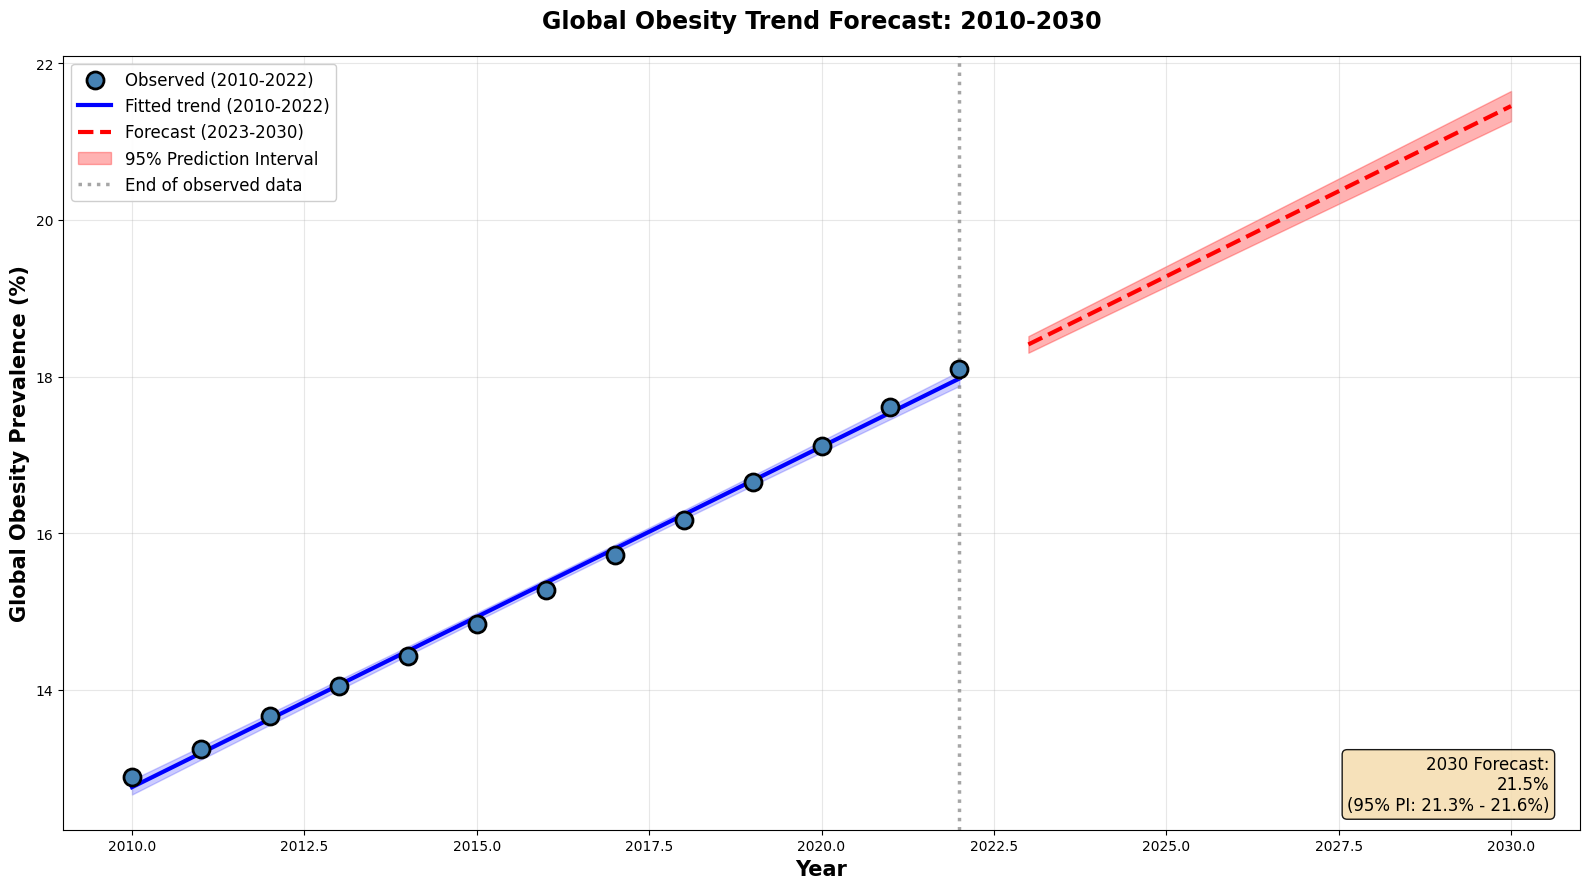

✅ Saved: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/outputs/plots/global_obesity_forecast_2030.png

📝 Forecast Summary:
   Linear trend projection suggests global adult obesity prevalence will reach approximately 21.5% by 2030 (95% PI: 21.3% – 21.6%), assuming current trends persist.


In [38]:
# Plot forecast
print("📊 Creating forecast visualization...")
fig, ax = plt.subplots(figsize=(16, 9))

# Observed data
observed_mask = df_forecast['observed'].notna()
ax.scatter(df_forecast.loc[observed_mask, 'year'], 
           df_forecast.loc[observed_mask, 'observed'],
           s=150, color='steelblue', marker='o', zorder=3, 
           label='Observed (2010-2022)', edgecolors='black', linewidth=2)

# Fitted line (2010-2022)
fitted_mask = (df_forecast['year'] <= 2022) & df_forecast['observed'].notna()
ax.plot(df_forecast.loc[fitted_mask, 'year'], 
        df_forecast.loc[fitted_mask, 'pred'],
        'b-', linewidth=3, label='Fitted trend (2010-2022)', zorder=2)

# Forecast line (2023-2030)
forecast_mask = df_forecast['year'] >= 2023
ax.plot(df_forecast.loc[forecast_mask, 'year'], 
        df_forecast.loc[forecast_mask, 'pred'],
        'r--', linewidth=3, label='Forecast (2023-2030)', zorder=2)

# Confidence intervals
ax.fill_between(df_forecast.loc[forecast_mask, 'year'],
                df_forecast.loc[forecast_mask, 'pred_low95'],
                df_forecast.loc[forecast_mask, 'pred_high95'],
                alpha=0.3, color='red', label='95% Prediction Interval', zorder=1)

# Historical confidence intervals (lighter)
ax.fill_between(df_forecast.loc[fitted_mask, 'year'],
                df_forecast.loc[fitted_mask, 'pred_low95'],
                df_forecast.loc[fitted_mask, 'pred_high95'],
                alpha=0.2, color='blue', zorder=1)

# Vertical line at 2022
ax.axvline(x=2022, color='gray', linestyle=':', linewidth=2.5, alpha=0.7, label='End of observed data')

ax.set_xlabel('Year', fontsize=15, fontweight='bold')
ax.set_ylabel('Global Obesity Prevalence (%)', fontsize=15, fontweight='bold')
ax.set_title('Global Obesity Trend Forecast: 2010-2030', fontsize=17, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=12, framealpha=0.95)
ax.grid(True, alpha=0.3)
ax.set_xlim(2009, 2031)

# Add 2030 prediction text
textstr = f'2030 Forecast:\n{pred_2030:.1f}%\n(95% PI: {ci_low_2030:.1f}% - {ci_high_2030:.1f}%)'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
ax.text(0.98, 0.02, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.savefig(OUTPUT_PLOTS / "global_obesity_forecast_2030.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {OUTPUT_PLOTS / 'global_obesity_forecast_2030.png'}")

# Summary sentence
summary_sentence = (
    f"Linear trend projection suggests global adult obesity prevalence will reach "
    f"approximately {pred_2030:.1f}% by 2030 (95% PI: {ci_low_2030:.1f}% – {ci_high_2030:.1f}%), "
    f"assuming current trends persist."
)
print(f"\n📝 Forecast Summary:")
print(f"   {summary_sentence}")


## Summary

This notebook performed three comprehensive analyses:

1. **Simple Linear Regression**: Obesity ~ FatShare
   - Explored the relationship between fat share and obesity
   - Generated diagnostic plots and saved predictions

2. **Multiple Regression**: Obesity ~ Diet Composition
   - Included multiple predictors (fat_share, energy_kcal_day, sugar_share, etc.)
   - Evaluated on train/test split
   - Computed standardized coefficients and VIF

3. **Global Trend Forecast**: 2010-2030
   - Population-weighted global average obesity trend
   - Forecast to 2030 with 95% prediction intervals
   - Comprehensive visualization

All outputs have been saved to `data/outputs/` directory.

---
